## Importing the necessary packages

In [3]:
import pandas as pd
import numpy as np
import scipy
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
import time

## Setting up the ability to import modules written for this project

In [4]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))

if module_path not in sys.path:
    sys.path.append(module_path)

## Importing modules written for this project

In [5]:
from models.neighborhood.ItembasedCF import ItembasedCF
from utils.baseline import baseline
from utils.data_split import data_split_train_test
from utils.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error
from utils.sampler import rec_sample

In [6]:
pd.options.mode.chained_assignment = None 

## Reading the input dataset from the data folder

In [64]:
playcount_df = pd.read_csv('../data/10kusers_500songs.csv')

## Generating a dataset with top 10,000 users and 100 items

In [27]:
# Generate a sample of required size
data_sample = rec_sample(df=playcount_df, user_field='user_id', item_field='song_id')
df = data_sample.generate_sample(users_n=10000, items_m=100)

In [103]:
# Sample Rows
df.head()

user_id             song_id  listen_count
0  76235885b32c4e8c82760c340dc54f9b608d7d7e  SOUFPNI12A8C142D19             1
1  791af5effd46a270b6a2dfa8385f3cfc135d6951  SOUFPNI12A8C142D19             2
2  a0f9ee71fbddc17a5738cda52f6ae21e2a0ceca0  SOUFPNI12A8C142D19             2
3  0720ca8f3cc2d0c0c126e784b846785536ddefbc  SOUFPNI12A8C142D19             3
4  47c312c5fa84af5c77b54b035ed0e1a38bc21bf6  SOUFPNI12A8C142D19             2

### Sparsity of the dataset

In [220]:
print ("Sparsity of the matrix:{0:.3f}".format(1 - df['user_id'].count()/(df['user_id'].nunique() * df['song_id'].nunique())))

Sparsity of the matrix:0.883


### Understanding the data

In [226]:
user_songcount = df.groupby('user_id')[['song_id']].count().reset_index()
user_songcount_distribution = user_songcount.groupby('song_id').count().reset_index()

#### Median number of songs listened to by the users (number of data points) and the distribution of the same

In [231]:
print ('Median number of songs listened to by the users:',user_songcount['song_id'].median())

Median number of songs listened to by the users: 8.0


#### The median number of songs - 8 indicates that the dataset chosen has relatively lower sparsity (in the context of recommender systems)

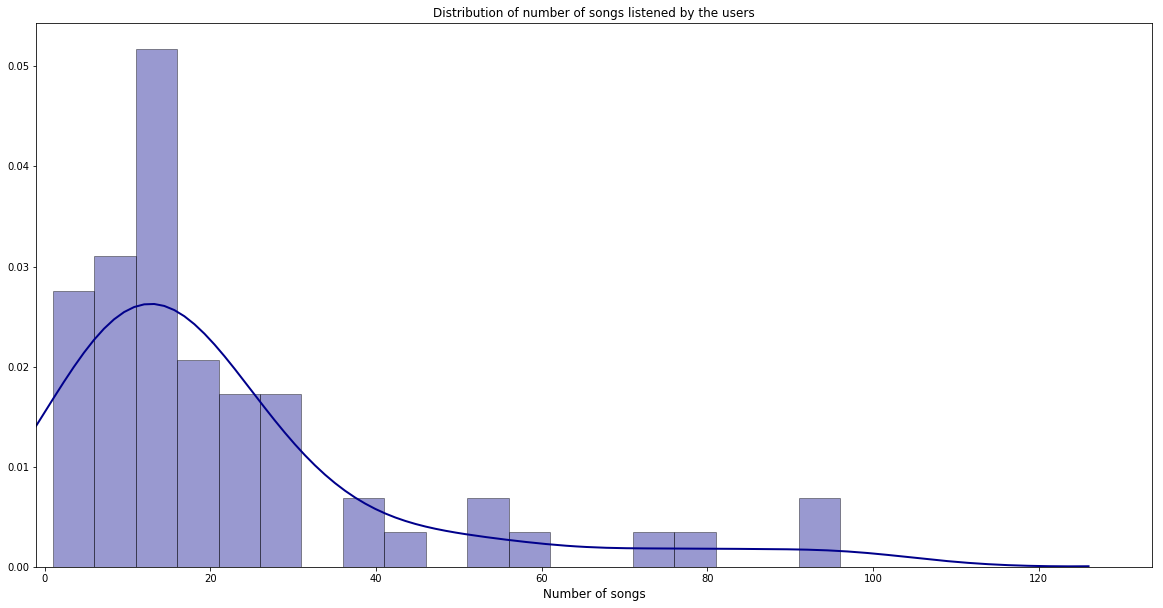

In [256]:
plt.figure(figsize=((20,10)))
# Filtering out users who have listened to more than 100 songs to increase legibility of the plot
sns.distplot(user_songcount_distribution[user_songcount_distribution['user_id']<100]['user_id'], hist=True, kde=True,
             bins=list(range(1,100,5)), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2, 'bw':10}).set(xlim=(-1))
plt.xlabel('Number of songs', fontsize=12)
# plt.xticks(list(range(0,800,25)))
plt.title('Distribution of number of songs listened by the users')
plt.show()

#### Median listening count and the distribution of the same across all users and songs

In [246]:
print ('Median listen count:',df['listen_count'].median())

Median listen count: 2.0


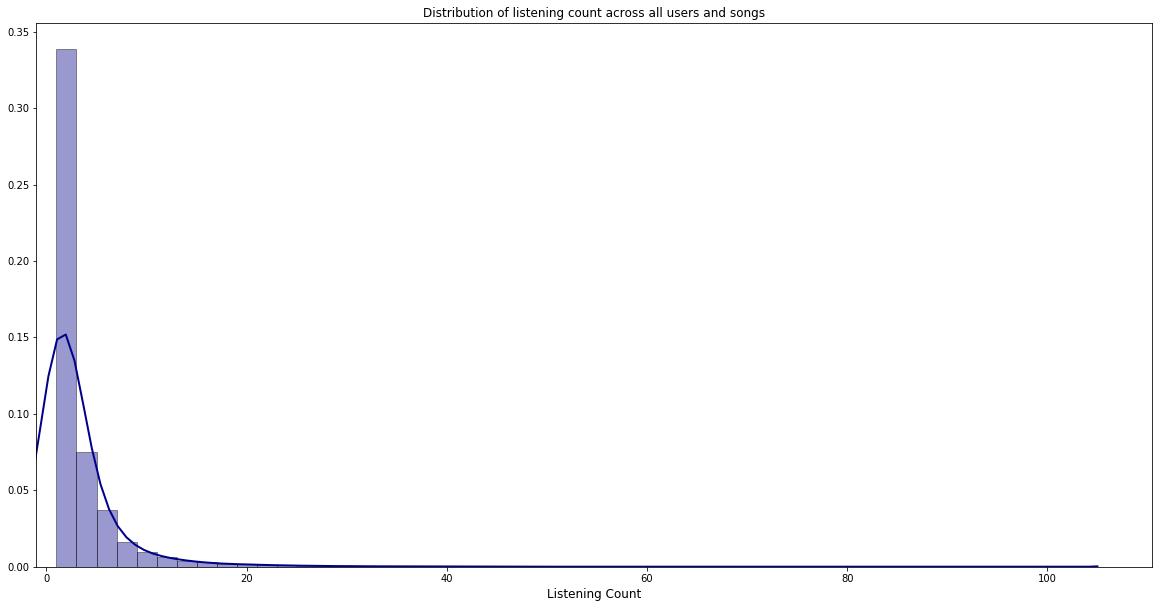

In [257]:
plt.figure(figsize=((20,10)))
# Filtering out data points wiht listen counts of more than 100 to increase legibility of the plot
sns.distplot(df[df['listen_count']<100]['listen_count'], hist=True, kde=True,
             bins=list(range(1,100,2)), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2, 'bw':2}).set(xlim=(-1))
plt.xlabel('Listening Count', fontsize=12)
plt.title('Distribution of listening count across all users and songs')
plt.show()

## Splitting into train, validation and test

In [28]:
split_data = data_split_train_test(df)
df_train, df_test = split_data.split_data_train_test_random(train_proportion=0.8, test_proportion=0.2, random_state=42)

split_data = data_split_train_test(df_train)
df_train, df_val = split_data.split_data_train_test_random(train_proportion=0.8, test_proportion=0.2, random_state=42)

## Function that sets up the model for multiple runs for comparison

In [7]:
def run_model(df_train, df_test, similarity_measure='cosine_adjusted', k=10, baseline_method='average'):
    model = ItembasedCF(k=k, similarity_measure=similarity_measure, baseline=baseline_method)
    model.fit(df_train, user_field='user_id', item_field='song_id', rec_field='listen_count')
    df_test_pred = model.predict(df_test, baseline_col=True)

    RMSE_test = root_mean_squared_error(df_test_pred['listen_count'], df_test_pred['pred'])
    MAE_test = mean_absolute_error(df_test_pred['listen_count'], df_test_pred['pred'])
    baseline_proportion = df_test_pred['baseline_col'].mean()

    baseline_pred = baseline(df_train, user_field='user_id', item_field='song_id', rec_field='listen_count')

    df_test_pred['baseline_average'] = df_test_pred.apply(lambda x:baseline_pred.baseline_average(x['user_id'], x['song_id']), axis=1)
    df_test_pred['baseline_item_average'] = df_test_pred.apply(lambda x:baseline_pred.baseline_item_average(x['user_id'], x['song_id']), axis=1)

    rmse_baseline_avg = root_mean_squared_error(df_test_pred['listen_count'].values, df_test_pred['baseline_average'].values)
    mae_baseline_avg = mean_absolute_error(df_test_pred['listen_count'].values, df_test_pred['baseline_average'].values)

    rmse_item_baseline_avg = root_mean_squared_error(df_test_pred['listen_count'].values, df_test_pred['baseline_item_average'].values)
    mae_item_baseline_avg = mean_absolute_error(df_test_pred['listen_count'].values, df_test_pred['baseline_item_average'].values)

    return {'similarity_measure':similarity_measure,
          'k':k,
          'baseline_method':baseline_method,
          'RMSE_pred_set':RMSE_test, 
          'MAE_pred_set':MAE_test, 
          'baseline_proportion':baseline_proportion, 
          'rmse_baseline_avg':rmse_baseline_avg, 
          'mae_baseline_avg':mae_baseline_avg, 
          'rmse_item_baseline_avg':rmse_item_baseline_avg, 
          'mae_item_baseline_avg':mae_item_baseline_avg
    }


## Measuring model performance on validation data across different similarity measures and values of neighborhood size

In [ ]:
ctr = 0
results = {}
for k in range(1,26):
    for similarity_measure in ['euclidian', 'pearson', 'cosine', 'cosine_adjusted']:
#         print (k)
        result_dict = run_model(df_train=df_train, df_test=df_val, similarity_measure=similarity_measure, k=k, baseline_method='item_average')
        results[ctr] = result_dict
        ctr += 1

In [51]:
results_df = pd.DataFrame(results)
results_df = results_df.T

In [102]:
results_df.head()

MAE_pred_set RMSE_pred_set baseline_method baseline_proportion  k  \
0      2.46746       8.66809    item_average            0.946412  1   
1      2.43986       8.66943    item_average            0.834088  1   
2      2.43104       8.67079    item_average            0.820394  1   
3      2.43606       8.72101    item_average             0.85876  1   
4      2.47273       8.72675    item_average             0.89656  2   

  mae_baseline_avg mae_item_baseline_avg rmse_baseline_avg  \
0          2.55304               2.45843           8.71793   
1          2.55304               2.45843           8.71793   
2          2.55304               2.45843           8.71793   
3          2.55304               2.45843           8.71793   
4          2.55304               2.45843           8.71793   

  rmse_item_baseline_avg similarity_measure  
0                8.62628          euclidian  
1                8.62628            pearson  
2                8.62628             cosine  
3                8.62628    cosine_adjusted  
4                8.62628          euclidian

## Plot of MAE at different similarity measures and values of K

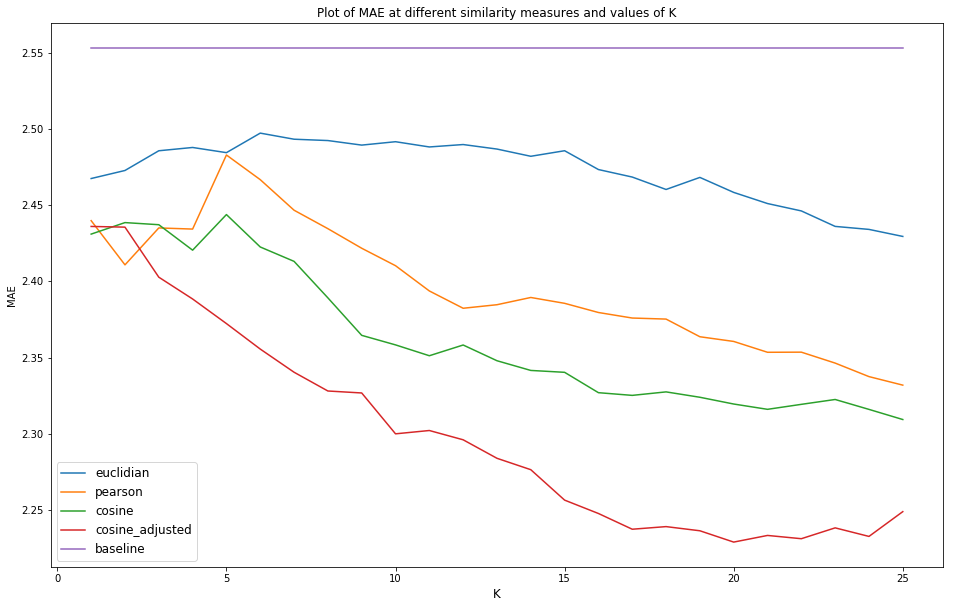

In [264]:
plt.figure(figsize=(16,10))
for val in ['euclidian', 'pearson', 'cosine', 'cosine_adjusted']:
    plt.plot(range(1,26),results_df[results_df['similarity_measure']==val]['MAE_pred_set'])
plt.plot(range(1,26), results_df['mae_baseline_avg'][:25])
plt.xlabel('K', fontsize=12)
plt.ylabel('MAE')
plt.title('Plot of MAE at different similarity measures and values of K')
plt.legend(['euclidian', 'pearson', 'cosine', 'cosine_adjusted', 'baseline'],prop={'size': 12})
plt.show()

### Observations
* ** We can clearly observe from the above graph that the MAE decreases with a larger neighborhood size**
* ** Euclidian Distance performs the worst among the similarity measures tested**
* ** Cosine Adjusted Similarity provides the best performance for our dataset. It also has the fastest drop in MAE with increasing K. **
* ** We see the lowest MAE for a value of _K = 20_. However, larger values of K take longer to run. Let's check the runtime below**

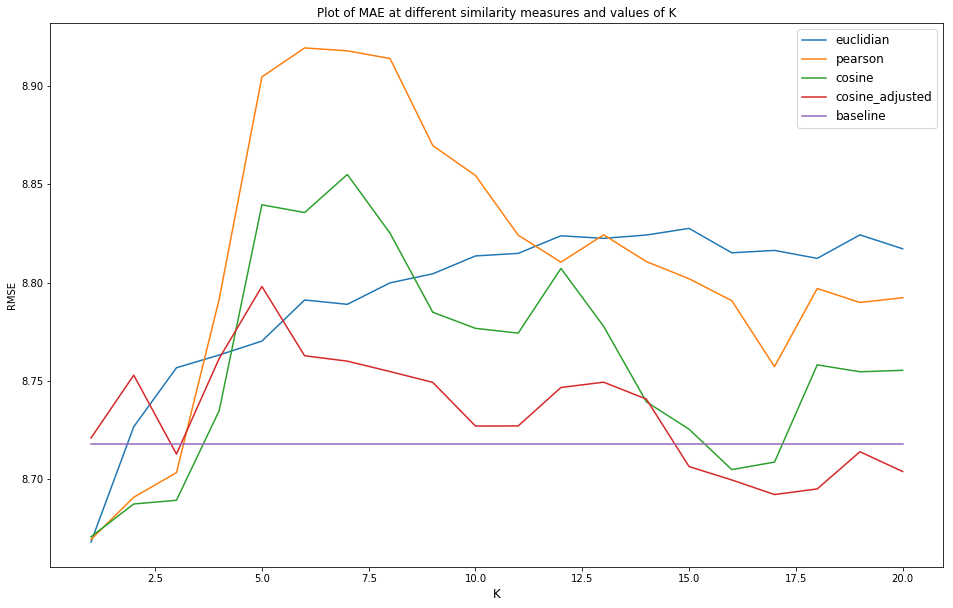

In [263]:
plt.figure(figsize=(16,10))
for val in ['euclidian', 'pearson', 'cosine', 'cosine_adjusted']:
    plt.plot(range(1,21),results_df[results_df['similarity_measure']==val]['RMSE_pred_set'][:20])
plt.plot(range(1,21), results_df['rmse_baseline_avg'][:20])
plt.xlabel('K', fontsize=12)
plt.ylabel('RMSE')
plt.title('Plot of MAE at different similarity measures and values of K')
plt.legend(['euclidian', 'pearson', 'cosine', 'cosine_adjusted', 'baseline'],prop={'size': 12})
plt.show()

### Observations
* ** Unlike the trend in MAE, the trend on RMSE is not very clear**
* ** The RMSE generally increases and then decreases**
* ** While the best RMSE is at k=1, a k value close to 20 for the cosine adjusted similarity does better than the baseline and aligns well with the MAE plot**
* ** We believe that MAE is more important than RMSE. The RMSE value for implicit feedback with a big range of listen counts is hard to get very accurate unless we are very conservative and we don't want to limit ourselves to that**

## Checking time of run for different values of K

In [ ]:
ctr = 0
results_time = {}
for k in range(1,26):
#     print (k)
    start_time = time.time()
    result_dict_time = run_model(df_train=df_train, df_test=df_val, similarity_measure='cosine_adjusted', k=k, baseline_method='item_average')
    results_time[ctr] = time.time() - start_time
    ctr += 1

In [74]:
results_time_df = pd.DataFrame(results_time, index=[0])
results_time_df = results_time_df.T
results_time_df.columns = ['time_seconds']

## Plot of running time for predicting listening counts in the validation dataset for different values of K

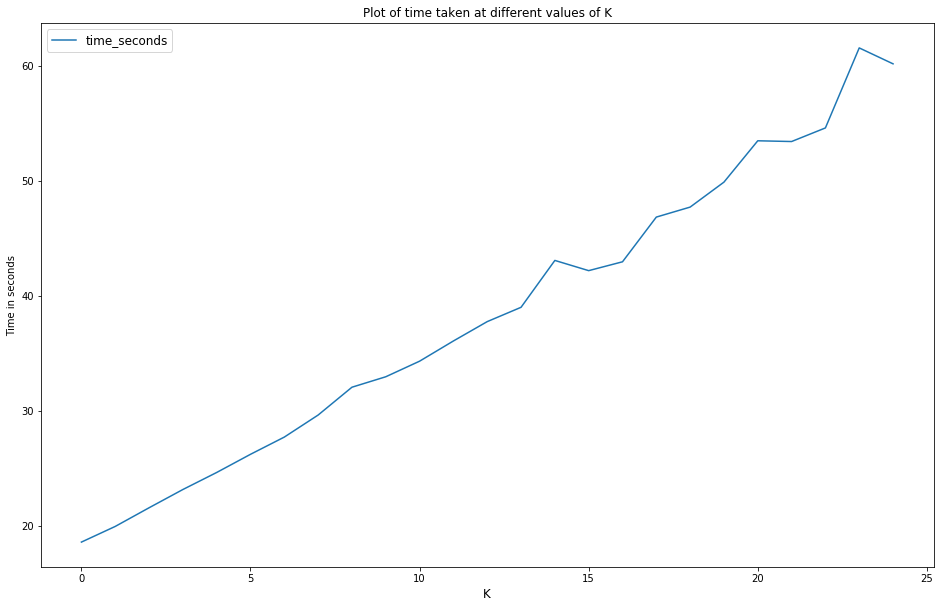

In [91]:
plt.figure(figsize=(16,10))
plt.plot(results_time_df['time_seconds'])
plt.xlabel('K', fontsize=12)
plt.ylabel('Time in seconds')
plt.title('Plot of time taken at different values of K')
plt.legend(prop={'size': 12})
plt.show()

### It can be clearly seen that the running time increases linearly with K. For applications that provide real-time predictions, there needs to be careful consideration of the performance vs time balance

## Checking performance on test set using the best parameters chosen obtained from validation

In [104]:
model = ItembasedCF(k=20, similarity_measure='cosine_adjusted', baseline='item_average')
model.fit(df_train, user_field='user_id', item_field='song_id', rec_field='listen_count')

In [107]:
df_train_pred = model.predict(df_train, baseline_col=True)

In [110]:
print ("Training Set MAE: {0:.3f}".format(mean_absolute_error(df_train_pred['listen_count'], df_train_pred['pred'])))
print ("Proportion of baseline predictions in the training set: {0:.3f}".format(df_train_pred['baseline_col'].mean()))

Training Set MAE: 2.077
Proportion of baseline predictions in the training set: 0.179


In [111]:
df_test_pred = model.predict(df_test, baseline_col=True)

In [112]:
print ("Test Set MAE: {0:.3f}".format(mean_absolute_error(df_test_pred['listen_count'], df_test_pred['pred'])))
print ("Proportion of baseline predictions in the test set: {0:.3f}".format(df_test_pred['baseline_col'].mean()))

Test Set MAE: 2.244
Proportion of baseline predictions in the test set: 0.176


* ** The training set MAE is 2.07 **
* ** The test set MAE of 2.24 is worse than the training set MAE as expected. But it is pretty close to the best validation MAE we obtained across the parameter space tested **

### Checking the model predictions for a sample user for whom the model had good predictions

In [116]:
sample_user = '002b63a7e2247de6d62bc62f253474edc7dd044c'
user_test_pred = df_test_pred[df_test_pred['user_id']=='002b63a7e2247de6d62bc62f253474edc7dd044c'].sort_values('listen_count', ascending=False)

In [122]:
song_info = pd.read_csv('../data/song_info.csv')[['song_id', 'artist_name', 'track_name']]

### Here are the listening count predictions for all the songs in the test data for that user

In [125]:
user_test_pred[['song_id', 'listen_count', 'pred']].reset_index(drop=True)

song_id  listen_count       pred
0   SOOFYTN12A6D4F9B35            17  13.782757
1   SOUNZHU12A8AE47481             9   8.263567
2   SORWLTW12A670208FA             8   2.493599
3   SOTEKMT12A67AD954E             4   3.267406
4   SOWEJXA12A6701C574             3   5.924552
5   SOFLJQZ12A6D4FADA6             2   4.852181
6   SOPQLBY12A6310E992             2   2.795607
7   SOPAYPV12AB017DB0C             2   3.116148
8   SONOYIB12A81C1F88C             2   4.819885
9   SODEYDM12A58A77072             1   4.208647
10  SOGPNGN12A8C143969             1   3.172471
11  SOZVCRW12A67ADA0B7             1   2.554648

### While the actual predictions are not exact, we can see a clear directional relationship. Songs which were listened to more times actually have a higher prediction, on average

### Adding song name and artist name

In [126]:
pd.merge(user_test_pred[['song_id', 'listen_count', 'pred']], song_info, how='inner', on='song_id').reset_index(drop=True)

song_id  listen_count       pred               artist_name  \
0   SOOFYTN12A6D4F9B35            17  13.782757           Alliance Ethnik   
1   SOUNZHU12A8AE47481             9   8.263567                Ron Carter   
2   SORWLTW12A670208FA             8   2.493599           Jimmy Eat World   
3   SOTEKMT12A67AD954E             4   3.267406               The Killers   
4   SOWEJXA12A6701C574             3   5.924552                  Coldplay   
5   SOFLJQZ12A6D4FADA6             2   4.852181                   Cartola   
6   SOPQLBY12A6310E992             2   2.795607                 Radiohead   
7   SOPAYPV12AB017DB0C             2   3.116148    Florence + The Machine   
8   SONOYIB12A81C1F88C             2   4.819885                Katy Perry   
9   SODEYDM12A58A77072             1   4.208647                  Cut Copy   
10  SOGPNGN12A8C143969             1   3.172471  The All-American Rejects   
11  SOZVCRW12A67ADA0B7             1   2.554648               The Killers   

             track_name  
0            Représente  
1   I CAN'T GET STARTED  
2            The Middle  
3          Read My Mind  
4               Fix You  
5              Tive Sim  
6      Creep (Explicit)  
7   You've Got The Love  
8       I Kissed A Girl  
9        Lights & Music  
10       Gives You Hell  
11  When You Were Young

### Surprisingly, the model does decently well even when the songs listened by the user where across many genres. But this is just one example.

### Analyzing test errors as a function of prediction data points

In [147]:
user_mae={}
for user in df_test_pred['user_id'].unique():
    user_mae[user] = {}
    mae = mean_absolute_error(df_test_pred[df_test_pred['user_id']==user]['listen_count'], df_test_pred[df_test_pred['user_id']==user]['pred'])
    number_pred = len(df_test_pred[df_test_pred['user_id']==user]['listen_count'])
    listen_count_mean = df_test_pred[df_test_pred['user_id']==user]['listen_count'].mean()
    user_mae[user]['mae_test'] = mae
    user_mae[user]['number_pred_test'] = number_pred
    user_mae[user]['listen_count_mean'] = listen_count_mean

user_mae = pd.DataFrame(user_mae).T

### The below dataset gives the average of the listen count for each user, the mae across test predictions and the number of test predictions

In [149]:
user_mae.head()

listen_count_mean  mae_test  \
00043d7bc800ceff4a90459e189eba5d442a1d3d           7.000000  6.000000   
000d80cd9b58a8f77b33aa613dcfc5cbf1daf5e8           1.000000  1.319751   
000ebc858861aca26bac9b49f650ed424cf882fc           1.000000  2.632143   
001fd039ab4472039d22f9481bb5c5d376c3032f           2.500000  1.939690   
002abc31db3d2d789395e728461156f1928a5a62           1.333333  0.333333   

                                          number_pred_test  
00043d7bc800ceff4a90459e189eba5d442a1d3d               1.0  
000d80cd9b58a8f77b33aa613dcfc5cbf1daf5e8               2.0  
000ebc858861aca26bac9b49f650ed424cf882fc               1.0  
001fd039ab4472039d22f9481bb5c5d376c3032f               4.0  
002abc31db3d2d789395e728461156f1928a5a62               3.0

In [196]:
user_mae_grouping = user_mae.groupby('number_pred_test').agg({'mae_test':'mean', 'listen_count_mean':'mean', 'number_pred_test':'count'})

In [197]:
user_mae_grouping.columns = ['listen_count_mean', 'mae_test_mean', 'user_count']
user_mae_grouping.reset_index(inplace=True)

#### The below dataset contains the average listening count, average mae, and number of users who had 1, 2, 3 predictions and so on in the test dataset

In [198]:
user_mae_grouping.head(n=10)

number_pred_test  listen_count_mean  mae_test_mean  user_count
0               1.0           2.578537       2.204675        2311
1               2.0           2.730940       2.138618        1574
2               3.0           2.775202       2.077828         992
3               4.0           3.057315       2.191827         663
4               5.0           3.079227       2.156149         414
5               6.0           3.222015       2.410988         268
6               7.0           3.151310       2.224210         169
7               8.0           3.205153       2.151935         131
8               9.0           3.194185       2.041020         107
9              10.0           4.259494       2.809864          79

#### We can see that the average listen count increases with number of predictions. This is expected - generally, users who listen to more songs also listen more frequently because they are engaged with the app. However, the MAE is bound to be larger when the listening counts are higher and so let's adjust the MAE by dividing it by the mean listening count (results in something along the lines of percentage error)

In [202]:
user_mae_grouping['mae_adjusted'] = user_mae_grouping['mae_test_mean'] / user_mae_grouping['listen_count_mean']

### Plot of the adjusted MAE across number of predictions (displaying only first 10 as the number of data points decreases a lot after 10)

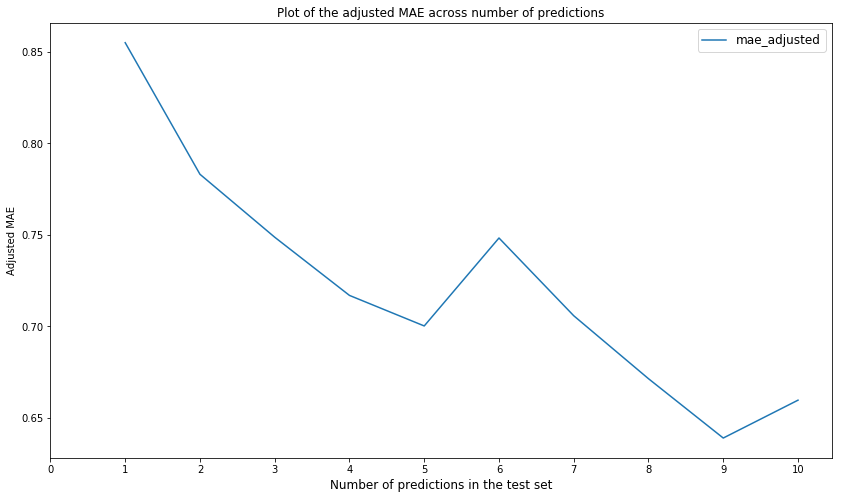

In [211]:
plt.figure(figsize=(14,8))
plt.plot(range(1,11), user_mae_grouping['mae_adjusted'][:10])
plt.xlabel('Number of predictions in the test set', fontsize=12)
plt.ylabel('Adjusted MAE')
plt.title('Plot of the adjusted MAE across number of predictions')
plt.legend(prop={'size': 12})
plt.xticks(range(11))
plt.show()

### We can see that as the number of predictions increases (indirectly indicating users with more data), the adjusted MAE decreases

### Let's take a look at the effect of increasing model size

### Function to regenerate samples of different sizes to understand the effect of model size on accuracy and run time

In [10]:
def generate_sample(users_n = 10000, items_m=100):

    data_sample = rec_sample(df=playcount_df, user_field='user_id', item_field='song_id')
    df = data_sample.generate_sample(users_n=users_n, items_m=items_m)

    split_data = data_split_train_test(df)
    df_train, df_test = split_data.split_data_train_test_random(train_proportion=0.8, test_proportion=0.2, random_state=42)

    split_data = data_split_train_test(df_train)
    df_train, df_val = split_data.split_data_train_test_random(train_proportion=0.8, test_proportion=0.2, random_state=42)
    
    return df_train, df_val, df_test

In [ ]:
ctr = 0
results_model_size = {}
results_time = {}
for item_size in range(100,251,25):
    df_train, df_val, df_test = generate_sample(users_n = 10000, items_m=item_size)
    start_time = time.time()
    result_dict_model_size = run_model(df_train=df_train, df_test=df_val, similarity_measure='cosine_adjusted', k=20, baseline_method='item_average')
    results_model_size[ctr] = result_dict_model_size
    results_time[ctr] = time.time() - start_time
    ctr += 1

In [13]:
results_df = pd.DataFrame(results_model_size)
results_df = results_df.T
results_time_df = pd.DataFrame(results_time, index=[0])
results_time_df = results_time_df.T
results_time_df.columns = ['time_seconds']

## Plot of MAE for different item set size

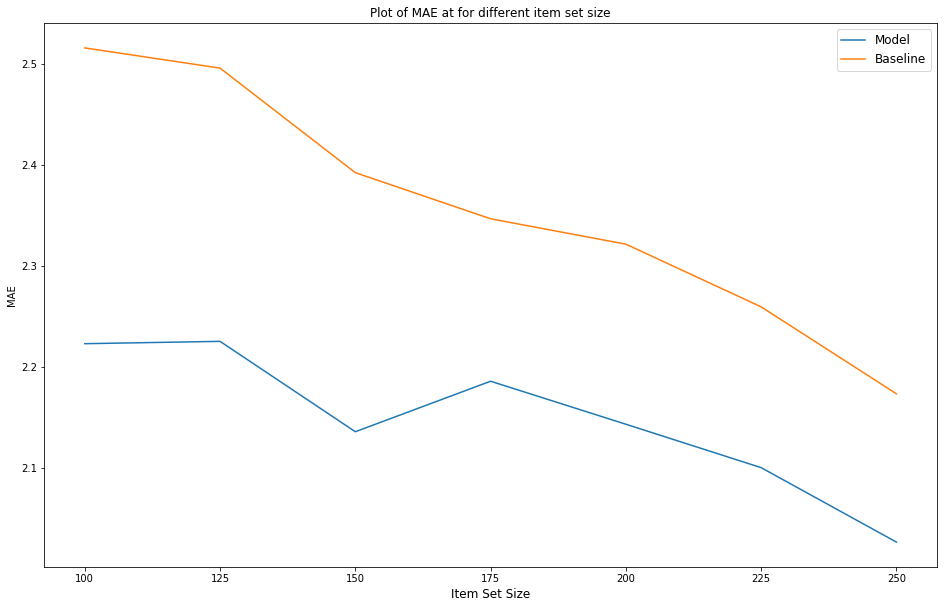

In [16]:
plt.figure(figsize=(16,10))
plt.plot(range(100,251,25), results_df['MAE_pred_set'])
plt.plot(range(100,251,25), results_df['mae_baseline_avg'])
plt.xlabel('Item Set Size', fontsize=12)
plt.ylabel('MAE')
plt.title('Plot of MAE at for different item set size')
plt.legend(['Model', 'Baseline'],prop={'size': 12})
plt.xticks(range(100,251,25))
plt.show()

### Observations
* ** We can clearly observe from the above graph that the MAE decreases with a larger model size (item set in this case)**
* ** This implies that there might be a performancs vs time tradeoff**
* ** Also, it's clear that the model MAE is lower than the baseline but they track each other closely for different item set sizes ** *


## Plot of running time for different item set size

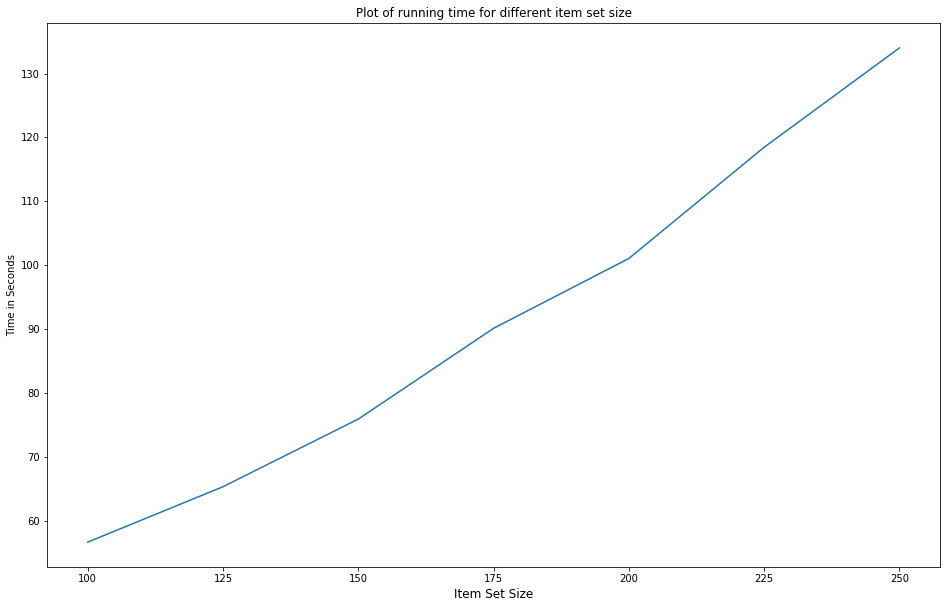

In [17]:
plt.figure(figsize=(16,10))
plt.plot(range(100,251,25), results_time_df['time_seconds'])
plt.xlabel('Item Set Size', fontsize=12)
plt.ylabel('Time in Seconds')
plt.title('Plot of running time for different item set size')
plt.xticks(range(100,251,25))
plt.show()

### Again, it can be clearly seen that the running time increases linearly with increase in model size (items in this case). For applications that require a fast response, the additional accuracy gained by using a larger model has to be weighed against the significant increase in run time

### In the next section, we will be exploring model based methods